In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

#Load Data CIFAR10

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)



trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(trainset)
trainset[0]

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4])


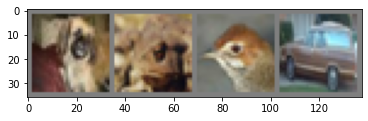

dog   frog  bird  car  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Device

In [6]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
else:
    print("-Type of precessor to be used: 'cpu'")

-Type of precessor to be used: 'gpu'


# Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = MyNet().to(device)
model

MyNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Optimizer and Loss function

In [8]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
#loss_func = nn.NLLLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop

In [9]:
# Function to evaluate one epoch of a CNN (No optimizer is needed).
def valid_epoch(data_loader, model, loss_func, device):
    """
    Args:
        data_loader: torch DataLoader.
        model:       torch model previously trained.
        device: 'gpu' or 'cpu'.
    Returns:
        Values of Loss Function and Accuracy after one epoch.
    """
# Initialize Loss Function, Accuracy, & number of points
    loss_sum = 0.
    correct= 0
    n_points = 0

# Put model in evaluation mode
    model.eval()

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy_true) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy_true = yy_true.to(device)
            yy_pred = model(xx)
        
# .compute loss function 
# (nn.CrossEntropyLoss requires target to be a 1D vector: [batch_size])
            loss = loss_func(yy_pred, yy_true)
            batch_size = len(yy_true)
            loss_sum += batch_size*loss.item()
            n_points += batch_size
        
# .compute accuracy (nn.Softmax output is a 1D vector: [batch_size])
            prob_softmax = nn.Softmax(dim=1)
#            pred = torch.max(prob_softmax(yy_pred), dim=1)[1]
            pred = torch.argmax(prob_softmax(yy_pred), 1)
            correct += (pred == yy_true).sum(dim=0).item()
        
    return loss_sum/n_points, correct/n_points

In [10]:
def accuracy(data_loader, model, device):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for i, (xx, yy_true) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy_true = yy_true.to(device)
            yy_pred = model(xx)
            predictions = torch.argmax(yy_pred, 1)
            # collect the correct predictions for each class
            for y, y_hat in zip(yy_true, predictions):
                if y == y_hat:
                    correct_pred[classes[y]] += 1
                total_pred[classes[y]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

  

In [11]:
def train(model, optimizer, loss_func, device, epochs=5):
    # .Loop Over Number of Epochs
    iteration = 0
    best_loss_valid = np.inf
#    epochs = 5
#    path_loss = {}
#    data_epoch = []

    for n_epoch in range(epochs):  # loop over the dataset multiple times

        loss_sum = 0.0
        n_points = 0
        model.train()
        for ibatch, (xx,yy_true) in enumerate(trainloader, 0):
            xx = xx.to(device)
            yy_true = yy_true.to(device)
            yy_pred = model(xx)
            loss = loss_func(yy_pred, yy_true)
        #...Acumulate Losses 
            batch_size = len(yy_true)
            loss_sum += batch_size*loss.item()
            n_points += batch_size
        
        #...Compute Gradients
            optimizer.zero_grad()
            loss.backward()
        #...Update Weights 
            optimizer.step()

        val_loss, val_acc = valid_epoch(testloader, model , loss_func, device)
    
    
        print(f'[{n_epoch}] loss: {loss_sum / n_points:.3f}', 
             "val loss: {:.3f}".format(val_loss), 
             "val acc: {:.2f}".format(val_acc))

    print('Finished Training')

In [12]:
train(model, optimizer, loss_func, device, epochs=5)


[0] loss: 1.508 val loss: 1.319 val acc: 0.53
[1] loss: 1.248 val loss: 1.201 val acc: 0.58
[2] loss: 1.141 val loss: 1.186 val acc: 0.59
[3] loss: 1.074 val loss: 1.141 val acc: 0.61
[4] loss: 1.028 val loss: 1.087 val acc: 0.62
Finished Training


In [13]:
accuracy(testloader, model, device)

Accuracy for class: plane is 63.4 %
Accuracy for class: car   is 72.4 %
Accuracy for class: bird  is 42.0 %
Accuracy for class: cat   is 33.6 %
Accuracy for class: deer  is 55.6 %
Accuracy for class: dog   is 59.5 %
Accuracy for class: frog  is 80.1 %
Accuracy for class: horse is 68.2 %
Accuracy for class: ship  is 84.5 %
Accuracy for class: truck is 63.5 %


In [14]:
correct_pred = {classname: 0 for classname in classes}
correct_pred

{'plane': 0,
 'car': 0,
 'bird': 0,
 'cat': 0,
 'deer': 0,
 'dog': 0,
 'frog': 0,
 'horse': 0,
 'ship': 0,
 'truck': 0}

# Pretrained Model

In [15]:
from torchvision import models

resnet = models.resnet34(pretrained=True)
resnet

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
layers = list(resnet.children())[:10]
layers

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [17]:
# this model just replaces the last layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
      #  for param in resnet.parameters():
      #      param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:6]
        self.top_model = nn.Sequential(*layers)
        self.fc = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = torch.flatten(x,1)    # flattening [batch,channel,size,size] -> [batch,channel]
        x = self.fc(x)
        return x

In [18]:
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)
labels

torch.Size([4, 3, 32, 32])
torch.Size([4])


tensor([5, 6, 4, 7])

In [19]:
model_1 = Net().to(device)
x = images.to(device)
y = labels.to(device)
#test = model_1.top_model(x)
test = model_1(x)
test.shape


torch.Size([4, 10])

In [20]:
y_hat = model_1(x)
y_hat

tensor([[ 0.3486, -0.0900,  0.4532,  0.0074,  0.0040, -0.1001,  0.0736,  0.0432,
          0.2200,  0.0484],
        [ 0.3155, -0.2197,  0.3660,  0.0257, -0.0490, -0.0544,  0.1987, -0.0356,
          0.2288, -0.1817],
        [ 0.3016, -0.1196,  0.5003,  0.0323, -0.1023, -0.1849,  0.1991,  0.0554,
          0.1377, -0.1247],
        [ 0.3795, -0.0922,  0.3647,  0.0743, -0.0027, -0.0293,  0.0157,  0.0828,
          0.1662, -0.0203]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [21]:
loss_func(y_hat, y).item()

2.381143569946289

In [22]:
model_1.top_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

#Optimizer with lr per layer

In [23]:
# Function to set up Adam optimizer with different learning rates
# for the different model's "children"
def setup_AdamOptimizer(model, lr0):
    """
    Input:
        model (nn.Module class): model previously instantiated
        lr0 (float): learning rate
    Output:
        optimizer with different learning rates for each child
    """
    params = [{'params': model.top_model.parameters(), 'lr': lr0/100},
              {'params': model.fc.parameters(), 'lr': lr0}]
    
    return optim.Adam(params, weight_decay=1e-4)

# Set up and instantiate optimizer
lr0 = 1e-2
optimizer_1 = setup_AdamOptimizer(model_1, lr0)

In [24]:
train(model_1, optimizer_1, loss_func, device, epochs=5)

[0] loss: 1.011 val loss: 0.642 val acc: 0.78
[1] loss: 0.664 val loss: 0.555 val acc: 0.81
[2] loss: 0.530 val loss: 0.544 val acc: 0.82
[3] loss: 0.438 val loss: 0.564 val acc: 0.82
[4] loss: 0.364 val loss: 0.570 val acc: 0.81
Finished Training


In [25]:
accuracy(testloader, model_1, device)

Accuracy for class: plane is 87.5 %
Accuracy for class: car   is 90.7 %
Accuracy for class: bird  is 87.0 %
Accuracy for class: cat   is 58.0 %
Accuracy for class: deer  is 79.2 %
Accuracy for class: dog   is 69.0 %
Accuracy for class: frog  is 86.0 %
Accuracy for class: horse is 83.4 %
Accuracy for class: ship  is 80.7 %
Accuracy for class: truck is 89.8 %


# Method 2

In [26]:
model_ft = models.resnet18(pretrained=True)
model_ft

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
num_ftrs = model_ft.fc.in_features
num_ftrs

512

In [28]:
model_ft.fc.out_features

1000

In [29]:
model_ft.fc = nn.Linear(512, 10)
model_ft.fc


Linear(in_features=512, out_features=10, bias=True)

In [30]:
optimizer_2 = optim.Adam(model.parameters(), lr=0.0001)
model_ft.to(device)
train(model_ft, optimizer_2, loss_func, device, epochs=5)

[0] loss: 2.699 val loss: 3.575 val acc: 0.10
[1] loss: 2.700 val loss: 3.493 val acc: 0.09
[2] loss: 2.699 val loss: 3.502 val acc: 0.10
[3] loss: 2.700 val loss: 3.310 val acc: 0.11
[4] loss: 2.702 val loss: 3.756 val acc: 0.11
Finished Training
